In [1]:
from prep_vis import *

In [2]:
from torchvision.transforms import functional as F
import random
from albumentations import (HorizontalFlip, Blur, GaussNoise, RandomCrop, RandomContrast, BboxParams, Rotate, Compos)

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_aug(min_area=0., min_visibility=0., train = True):
    aug_test = [ToTensor]
    aug = [ToTensor, HorizontalFlip(p = 0.5), Blur(p = 0.5), GaussNoise(p = 0.5), RandomCrop(height = random.randint(350, 480), width = random.randint(500, 640), p = 0.5), RandomContrast(p = 0.5), Rotate(p = 0.5, limit = 10)]
    if train:
        return Compose(aug, bbox_params=BboxParams(format='coco', min_area=min_area, min_visibility=min_visibility, label_fields=['category_id']))
    else:
        return Compose(aug_test, bbox_params=BboxParams(format='coco', min_area=min_area, min_visibility=min_visibility, label_fields=['category_id']))


In [9]:
train = CocoDetection_(root = "images",
                       annFile = "train.json",
                       transforms=get_aug([HorizontalFlip()]))
train[0]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [23]:
from torchvision.transforms import ToTensor
get_aug([HorizontalFlip()])(ToTensor()(train[0][0]).numpy())

AssertionError: force_apply must have bool or int type

In [22]:
(ToTensor()(train[0][0]))

tensor([[[0.3529, 0.3490, 0.3569,  ..., 0.3294, 0.3333, 0.3333],
         [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3804, 0.3686],
         [0.3608, 0.3608, 0.3490,  ..., 0.3647, 0.3412, 0.3451],
         ...,
         [0.4039, 0.4039, 0.3922,  ..., 0.2745, 0.2706, 0.2510],
         [0.4118, 0.4157, 0.3882,  ..., 0.3098, 0.2784, 0.2706],
         [0.4078, 0.4118, 0.3765,  ..., 0.3137, 0.2980, 0.2941]],

        [[0.3529, 0.3490, 0.3569,  ..., 0.3294, 0.3333, 0.3333],
         [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3804, 0.3686],
         [0.3608, 0.3608, 0.3490,  ..., 0.3647, 0.3412, 0.3451],
         ...,
         [0.4039, 0.4039, 0.3922,  ..., 0.2745, 0.2706, 0.2510],
         [0.4118, 0.4157, 0.3882,  ..., 0.3098, 0.2784, 0.2706],
         [0.4078, 0.4118, 0.3765,  ..., 0.3137, 0.2980, 0.2941]],

        [[0.3529, 0.3490, 0.3569,  ..., 0.3294, 0.3333, 0.3333],
         [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3804, 0.3686],
         [0.3608, 0.3608, 0.3490,  ..., 0.3647, 0.3412, 0.

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


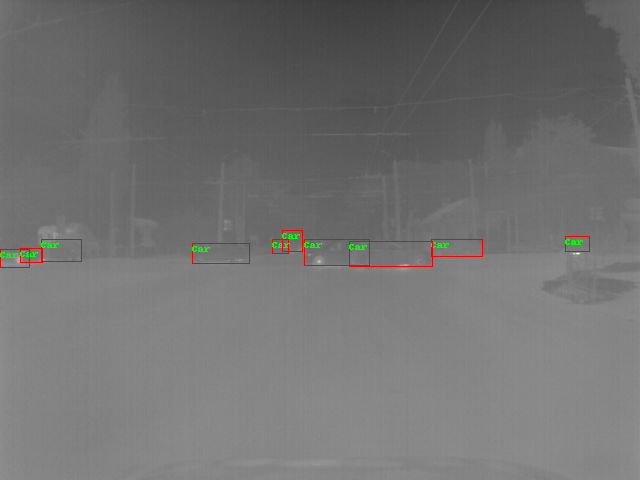

In [40]:
import transforms as T
from torchvision.transforms import ToPILImage
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

train = CocoDetection_(root = "images",
                       annFile = "train.json",
                       transforms=get_transform(train=False))
visualize_boxes([ToPILImage()(train[12][0]), train[12][1]])


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


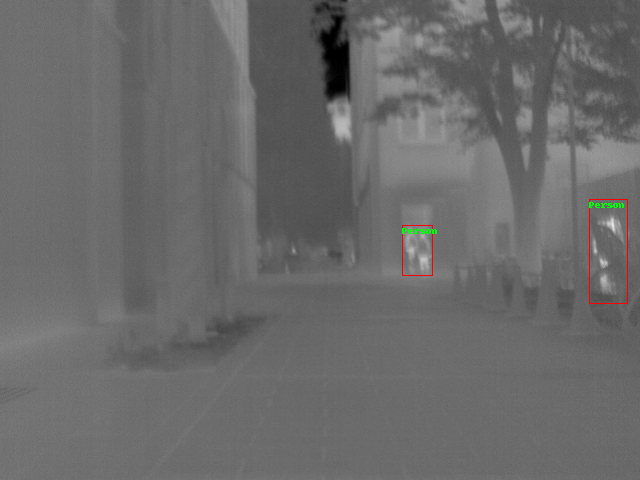

In [12]:
train = Pretrain(root = "fir",
                       annFile = "train_fir.json")
visualize_boxes(train[101])

In [4]:
import torch
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load("model_state_4_epochs"))
device = torch.device('cuda:1')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

import torch
#device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# use our dataset and defined transformations
dataset = CocoDetection_(root="images", annFile="train.json",
                         transforms=get_aug(train=True))
dataset_test = CocoDetection_(root="images", annFile="train.json",
                              transforms=get_aug(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
#device = torch.device('cuda:1') #if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

#model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [9]:
num_epochs = 5

for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
    lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/182]  eta: 0:02:37  lr: 0.000033  loss: 0.0781 (0.0781)  loss_classifier: 0.0233 (0.0233)  loss_box_reg: 0.0199 (0.0199)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0320 (0.0320)  time: 0.8666  data: 0.2679  max mem: 0
Epoch: [0]  [ 10/182]  eta: 0:00:43  lr: 0.000309  loss: 0.1303 (0.1221)  loss_classifier: 0.0516 (0.0514)  loss_box_reg: 0.0501 (0.0499)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0110 (0.0163)  time: 0.2547  data: 0.0307  max mem: 0
Epoch: [0]  [ 20/182]  eta: 0:00:36  lr: 0.000585  loss: 0.1420 (0.1426)  loss_classifier: 0.0541 (0.0603)  loss_box_reg: 0.0501 (0.0525)  loss_objectness: 0.0039 (0.0053)  loss_rpn_box_reg: 0.0127 (0.0245)  time: 0.1932  data: 0.0070  max mem: 0
Epoch: [0]  [ 30/182]  eta: 0:00:32  lr: 0.000860  loss: 0.1824 (0.1708)  loss_classifier: 0.0689 (0.0714)  loss_box_reg: 0.0646 (0.0597)  loss_objectness: 0.0064 (0.0071)  loss_rpn_box_reg: 0.0247 (0.0327)  time: 0.1949  data: 0.0072  max mem: 0
Epoch: [0]  

Epoch: [1]  [ 80/182]  eta: 0:00:20  lr: 0.005000  loss: 0.2288 (0.2289)  loss_classifier: 0.1002 (0.0997)  loss_box_reg: 0.0772 (0.0799)  loss_objectness: 0.0052 (0.0108)  loss_rpn_box_reg: 0.0242 (0.0386)  time: 0.1959  data: 0.0068  max mem: 0
Epoch: [1]  [ 90/182]  eta: 0:00:18  lr: 0.005000  loss: 0.2076 (0.2215)  loss_classifier: 0.0852 (0.0956)  loss_box_reg: 0.0712 (0.0768)  loss_objectness: 0.0048 (0.0106)  loss_rpn_box_reg: 0.0284 (0.0384)  time: 0.1941  data: 0.0065  max mem: 0
Epoch: [1]  [100/182]  eta: 0:00:16  lr: 0.005000  loss: 0.1788 (0.2184)  loss_classifier: 0.0765 (0.0938)  loss_box_reg: 0.0599 (0.0759)  loss_objectness: 0.0032 (0.0105)  loss_rpn_box_reg: 0.0193 (0.0381)  time: 0.1942  data: 0.0064  max mem: 0
Epoch: [1]  [110/182]  eta: 0:00:14  lr: 0.005000  loss: 0.2174 (0.2205)  loss_classifier: 0.0800 (0.0962)  loss_box_reg: 0.0779 (0.0769)  loss_objectness: 0.0066 (0.0104)  loss_rpn_box_reg: 0.0209 (0.0370)  time: 0.1945  data: 0.0064  max mem: 0
Epoch: [1]  

Epoch: [2]  [160/182]  eta: 0:00:04  lr: 0.005000  loss: 0.1772 (0.2023)  loss_classifier: 0.0638 (0.0826)  loss_box_reg: 0.0761 (0.0738)  loss_objectness: 0.0049 (0.0085)  loss_rpn_box_reg: 0.0154 (0.0375)  time: 0.1948  data: 0.0069  max mem: 0
Epoch: [2]  [170/182]  eta: 0:00:02  lr: 0.005000  loss: 0.1734 (0.2026)  loss_classifier: 0.0707 (0.0837)  loss_box_reg: 0.0744 (0.0739)  loss_objectness: 0.0055 (0.0085)  loss_rpn_box_reg: 0.0154 (0.0366)  time: 0.1952  data: 0.0068  max mem: 0
Epoch: [2]  [180/182]  eta: 0:00:00  lr: 0.005000  loss: 0.2058 (0.2069)  loss_classifier: 0.0762 (0.0849)  loss_box_reg: 0.0744 (0.0754)  loss_objectness: 0.0087 (0.0085)  loss_rpn_box_reg: 0.0197 (0.0380)  time: 0.1954  data: 0.0068  max mem: 0
Epoch: [2]  [181/182]  eta: 0:00:00  lr: 0.005000  loss: 0.2204 (0.2070)  loss_classifier: 0.0744 (0.0849)  loss_box_reg: 0.0686 (0.0753)  loss_objectness: 0.0095 (0.0085)  loss_rpn_box_reg: 0.0212 (0.0383)  time: 0.1911  data: 0.0067  max mem: 0
Epoch: [2] T

Epoch: [4]  [  0/182]  eta: 0:01:33  lr: 0.000500  loss: 0.1260 (0.1260)  loss_classifier: 0.0572 (0.0572)  loss_box_reg: 0.0569 (0.0569)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 0.5117  data: 0.3087  max mem: 0
Epoch: [4]  [ 10/182]  eta: 0:00:38  lr: 0.000500  loss: 0.1260 (0.1366)  loss_classifier: 0.0565 (0.0507)  loss_box_reg: 0.0446 (0.0441)  loss_objectness: 0.0034 (0.0045)  loss_rpn_box_reg: 0.0143 (0.0374)  time: 0.2225  data: 0.0338  max mem: 0
Epoch: [4]  [ 20/182]  eta: 0:00:33  lr: 0.000500  loss: 0.1169 (0.1281)  loss_classifier: 0.0551 (0.0528)  loss_box_reg: 0.0416 (0.0447)  loss_objectness: 0.0031 (0.0044)  loss_rpn_box_reg: 0.0148 (0.0262)  time: 0.1919  data: 0.0062  max mem: 0
Epoch: [4]  [ 30/182]  eta: 0:00:30  lr: 0.000500  loss: 0.1484 (0.1434)  loss_classifier: 0.0609 (0.0577)  loss_box_reg: 0.0463 (0.0495)  loss_objectness: 0.0030 (0.0050)  loss_rpn_box_reg: 0.0161 (0.0311)  time: 0.1905  data: 0.0062  max mem: 0
Epoch: [4]  

In [20]:
torch.save(model.state_dict(), "model_state_4_epochs")

In [ ]:
device

In [8]:
evaluate(model, data_loader_test, device=device)

Test:  [ 0/50]  eta: 0:00:28  model_time: 0.2995 (0.2995)  evaluator_time: 0.0018 (0.0018)  time: 0.5659  data: 0.2615  max mem: 0
Test:  [49/50]  eta: 0:00:00  model_time: 0.0370 (0.0428)  evaluator_time: 0.0021 (0.0037)  time: 0.0467  data: 0.0035  max mem: 0
Test: Total time: 0:00:02 (0.0586 s / it)
Averaged stats: model_time: 0.0370 (0.0428)  evaluator_time: 0.0021 (0.0037)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]

In [9]:

test = Test(root="images",
            annFile="test_info.json",
            transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [24]:
model.eval()
preds = []
with torch.no_grad():
    for image, id in test:
        outputs = model([image.to(device)])
        outputs = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in outputs]
        preds.append((id, outputs[0]))
    #torch.cuda.empty_cache()

In [25]:
def get_bbox(bbox):
    return [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
with open('output.json', "w") as f:
    f.write("[")
    for id, out in preds:
        out['boxes'] = out['boxes'].numpy()
        out['labels'] = out['labels'].numpy()
        out['scores'] = out['scores'].numpy()
        for k in range(len(out['labels'])):
            f.write('{"image_id": ' + str(id) + ", ")
            f.write('"category_id": ' + str(out['labels'][k]) + ", ")
            f.write('"bbox": ' + str(get_bbox(out['boxes'][k])) + ", ")
            f.write('"score": ' + str(out['scores'][k]) + "}, ")
    f.seek(f.tell() - 2, os.SEEK_SET)
    f.write(']')
    

In [16]:
preds

[{'boxes': tensor([[250.9182, 246.6511, 283.9086, 271.7288],
          [126.2712, 247.6513, 183.7169, 282.8350],
          [191.6227, 243.8434, 226.6980, 270.8004],
          [595.1060, 235.1190, 617.9084, 310.1059],
          [328.0247, 245.9909, 344.8474, 258.1284],
          [576.3970, 230.6239, 618.7540, 317.0557],
          [224.8421, 228.7024, 255.0508, 262.8054],
          [574.4158, 254.6751, 588.3925, 305.4624],
          [234.7507, 253.6264, 250.0840, 263.8937],
          [330.6338, 245.6496, 355.3157, 258.4998],
          [192.7691, 253.8184, 200.6232, 273.0845],
          [572.5269, 250.7957, 599.1564, 309.9261],
          [228.8271, 241.8398, 251.3321, 261.8099]]),
  'labels': tensor([2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2]),
  'scores': tensor([0.9982, 0.9970, 0.9895, 0.8609, 0.8502, 0.4884, 0.3248, 0.3038, 0.0931,
          0.0877, 0.0761, 0.0628, 0.0514])},
 {'boxes': tensor([[216.7183, 243.4216, 248.1315, 265.8491],
          [ 53.6540, 243.1134, 164.0822, 305.0087],
  

In [4]:
!git pull

Username for 'https://github.com': ^C
